Predicting crude oil price based on multivariate model - LSTM and GRU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from sklearn.model_selection import train_test_split as split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from google.colab import files
from keras.optimizers import SGD
from IPython.display import display, Image

1. Data Collection

In [ ]:
# Read data
df = pd.read_csv("/content/COMBINED.csv")

In [ ]:
df.head(10)

,Date,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
0,04-01-2000,25.55,282.7,1411.75,100.10,6.499,289.10
1,05-01-2000,24.91,281.1,1413.50,100.05,6.599,292.64
2,06-01-2000,24.78,281.4,1404.00,100.34,6.540,297.70
3,07-01-2000,24.22,281.9,1460.50,100.50,6.513,NaN
4,10-01-2000,24.67,281.7,1475.00,100.65,6.554,294.37
5,11-01-2000,25.77,283.4,1454.25,100.26,6.659,298.00
6,12-01-2000,26.28,282.7,1442.00,100.33,6.701,299.00
7,13-01-2000,26.69,284.1,1458.50,100.67,6.632,302.24
8,14-01-2000,28.02,283.9,1478.00,101.45,6.688,311.00
9,18-01-2000,28.85,288.6,1469.50,101.65,6.753,NaN


dataset is from 2000-2019

2. Data cleaning

In [ ]:
# Let's look at the datatype of each column
df.dtypes

Date                object
WTI                float64
GOLD               float64
SP 500             float64
US DOLLAR INDEX    float64
US 10YR BOND       float64
DJU                float64
dtype: object

In [ ]:
#length of dataframe
print(len(df))

4947


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4947 non-null   object 
 1   WTI              4947 non-null   float64
 2   GOLD             4941 non-null   float64
 3   SP 500           4946 non-null   float64
 4   US DOLLAR INDEX  4917 non-null   float64
 5   US 10YR BOND     4920 non-null   float64
 6   DJU              4859 non-null   float64
dtypes: float64(6), object(1)
memory usage: 270.7+ KB


In [ ]:
df.describe()

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
count,4947.000000,4941.000000,4946.000000,4917.000000,4920.000000,4859.000000
mean,62.068803,943.852311,1544.704848,90.503182,3.453490,459.169801
std,26.470270,473.656860,544.716725,11.691564,1.222532,147.334229
min,17.450000,255.100000,676.000000,71.304000,1.358000,167.570007
25%,40.115000,424.000000,1150.250000,80.946000,2.382000,359.664994
50%,59.300000,1088.500000,1356.250000,88.350000,3.389500,438.119995
75%,83.725000,1329.800000,1945.687500,96.940000,4.413000,553.309998
max,145.290000,1888.700000,2948.500000,121.210000,6.790000,812.909973


In [ ]:
#checking for null values
df.isnull().sum()

Date                0
WTI                 0
GOLD                6
SP 500              1
US DOLLAR INDEX    30
US 10YR BOND       27
DJU                88
dtype: int64

In [ ]:
#Filling Missing Values with mean values
df.fillna(df.mean(), inplace=True)
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Date               0
WTI                0
GOLD               0
SP 500             0
US DOLLAR INDEX    0
US 10YR BOND       0
DJU                0
dtype: int64

In [ ]:
#Converting Date column as DateTime format
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.dtypes

Date               datetime64[ns]
WTI                       float64
GOLD                      float64
SP 500                    float64
US DOLLAR INDEX           float64
US 10YR BOND              float64
DJU                       float64
dtype: object

In [ ]:
#Setting Date as Index
df.set_index('Date',inplace=True)
df.head(10)

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
Date,,,,,,
2000-01-04,25.55,282.7,1411.75,100.10,6.499,289.100000
2000-01-05,24.91,281.1,1413.50,100.05,6.599,292.640000
2000-01-06,24.78,281.4,1404.00,100.34,6.540,297.700000
2000-01-07,24.22,281.9,1460.50,100.50,6.513,459.169801
2000-01-10,24.67,281.7,1475.00,100.65,6.554,294.370000
2000-01-11,25.77,283.4,1454.25,100.26,6.659,298.000000
2000-01-12,26.28,282.7,1442.00,100.33,6.701,299.000000
2000-01-13,26.69,284.1,1458.50,100.67,6.632,302.240000
2000-01-14,28.02,283.9,1478.00,101.45,6.688,311.000000


3. EDA

In [ ]:
# import the adfuller function from statsmodel package to perform ADF test
from statsmodels.tsa.stattools import adfuller
 
# read the dataset using pandas read_csv() function
data = df.index
# extracting only the passengers count using values function
values = data.values
# passing the extracted passengers count to adfuller function, result of adfuller function is stored in a res variable
res = adfuller(values) 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: 2.098465
p-value: 0.998788
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Since, p-value>0.05, means data is stationary.

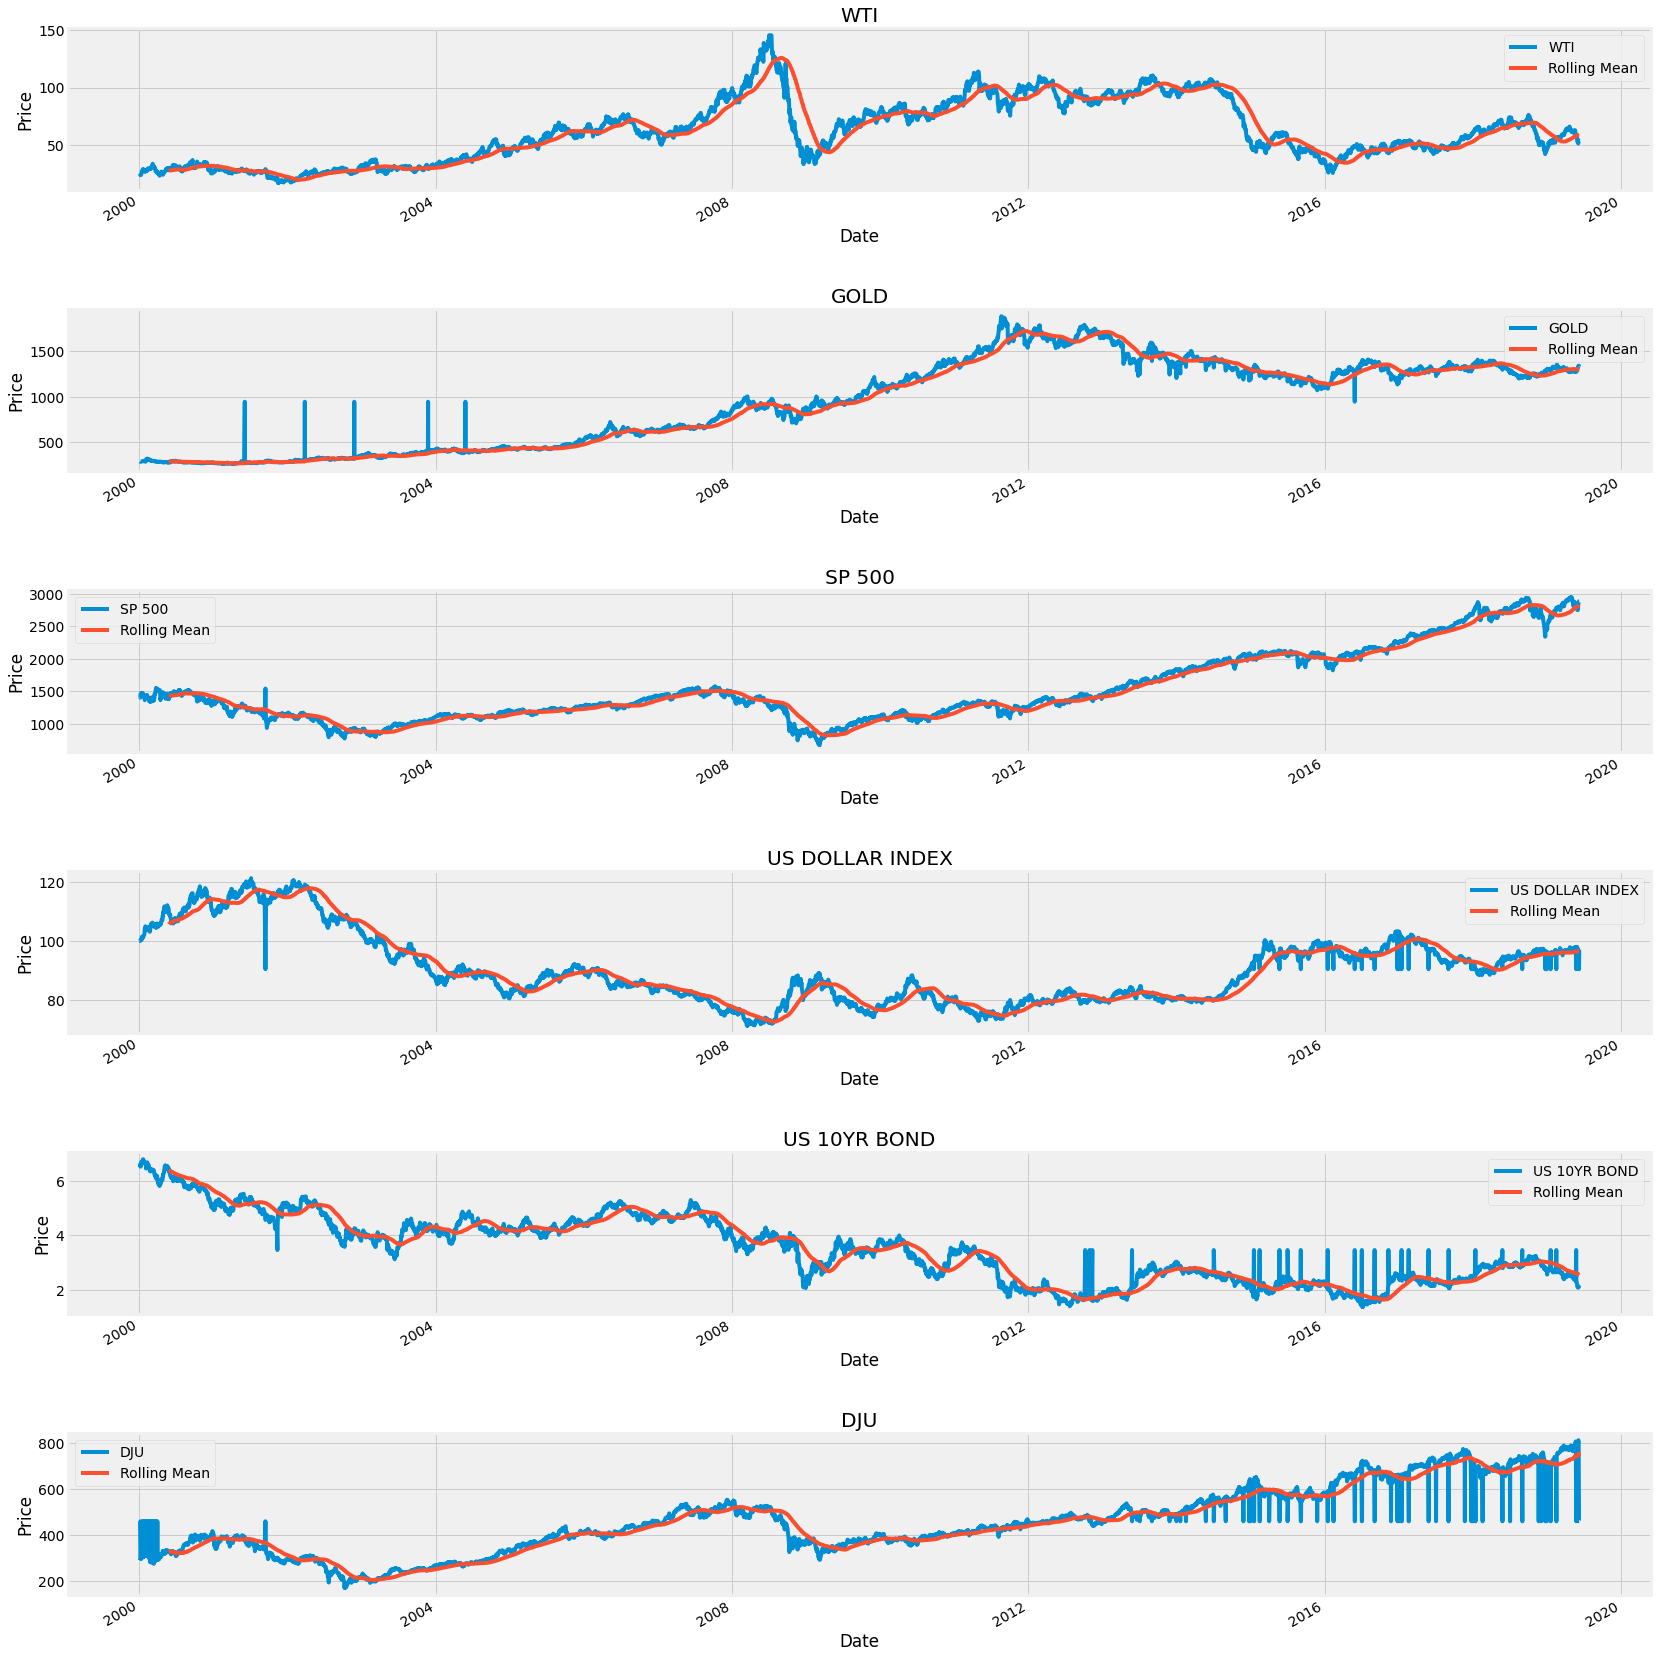

In [ ]:
##Line Plots Target & Features
data = df
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

-> WTI has mix of both UP and DOWN trends.

-> Gold, DJU has UP Trend.

-> US Dollar Index, US 10YR Bond has downward trend.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

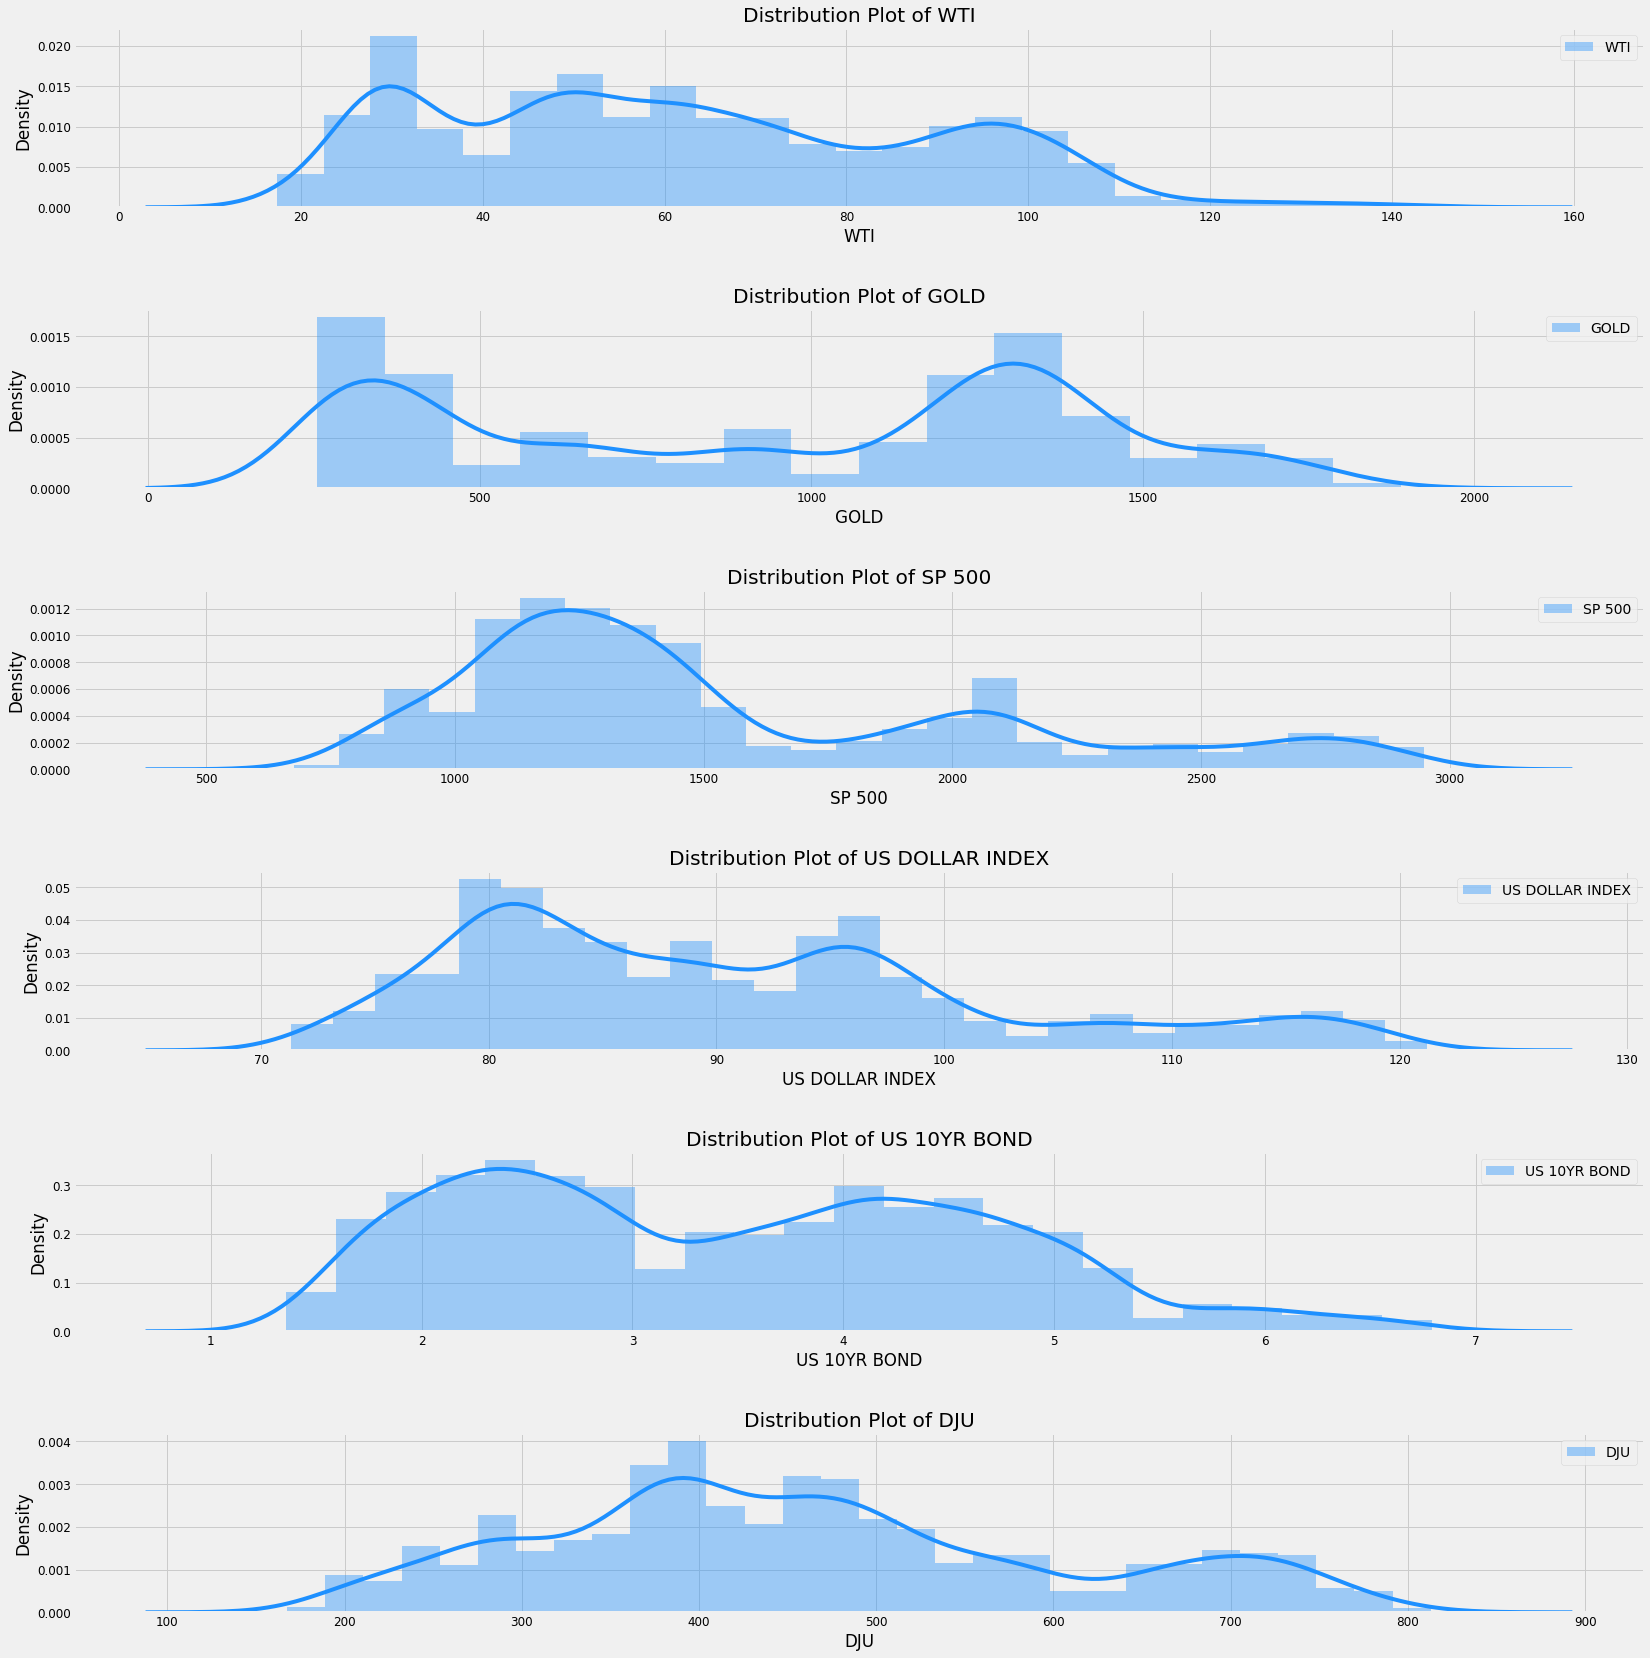

In [ ]:
#Checking if Target and Features follow Normal Distribution
data = df
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
col_names = data.columns
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  sns.distplot(data.iloc[:,i],label=col_names[i],color='dodgerblue').set_title("Distribution Plot of {}".format(col_names[i]),axes=ax)
  ax.tick_params(labelsize=12)
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

-> Most frequent values of WTI are in the range of 25 to 35.

-> The WTI oil price values above 120 are less frequent.

-> All Features & WTI don't follow Normal Distribution.

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

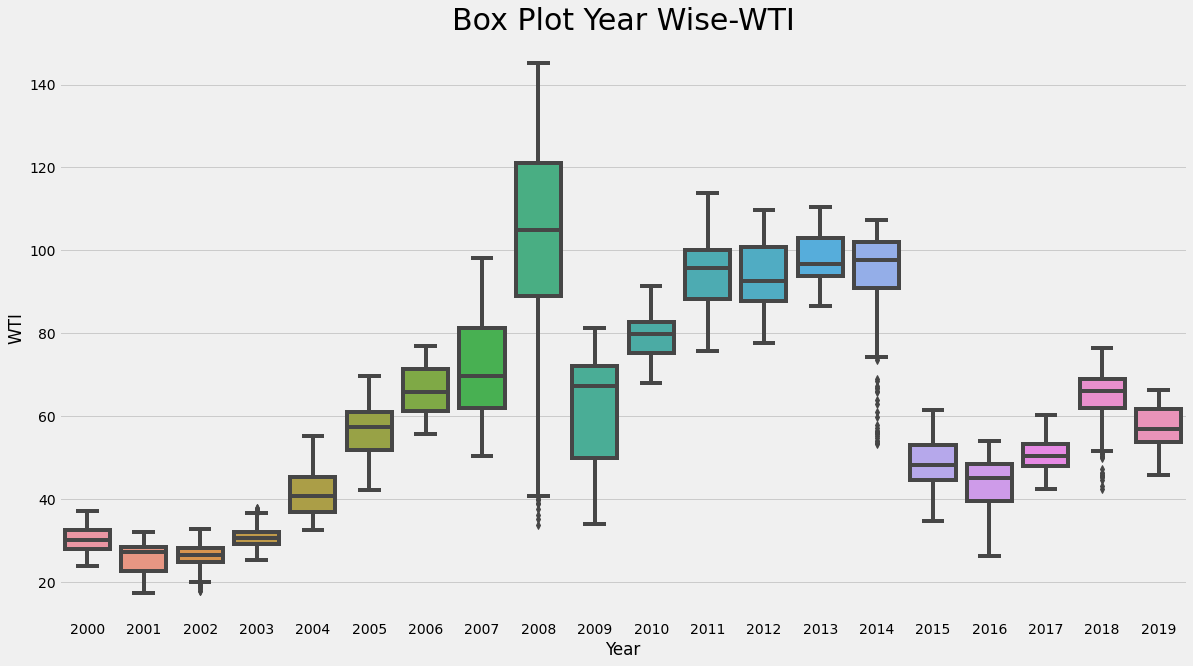

In [ ]:
## Temporary DataFrame
temp_data = df
temp_data['Year'] = df.index.year
##Box Plot Year Wise WTI
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=temp_data['Year'], y=temp_data['WTI'])
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

-> During the years 2007, 2008, and 2009 wide variations in the values of WTI have been observed.

-> In the year 2008, which is the period of the financial crisis and huge volatality, the WTI oil price varies between 30-140$.

-> Years 2002, 2008, 2014 & 2018 show outliers.

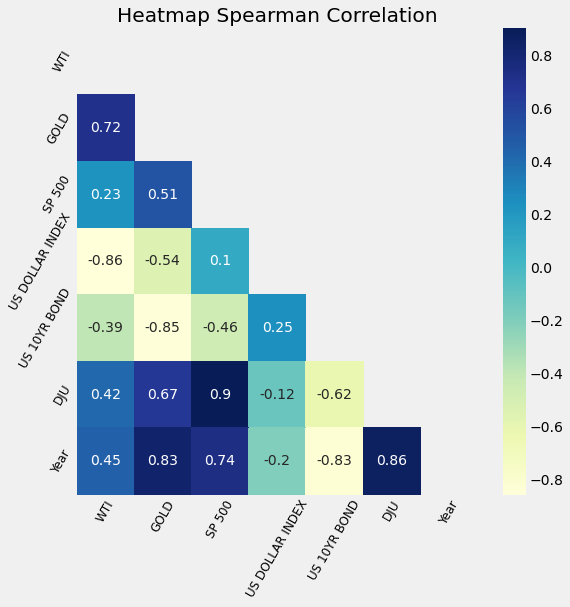

In [ ]:
#HeatMap Spearman Correlation
plt.figure(figsize=(8,8))
matrix = np.triu(df.corr(method='spearman'))
heat_map = sns.heatmap(df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

-> The highest positive correlation with target variable WTI is with Gold(ρ:0.72)

-> We also observe that SP500 and WTI have less correlation.(ρ : 0.23)

-> US 10 YR Bond and WTI are moderately inversely correlated.(ρ : -0.39)

-> DJU & WTI positive moderate correlation.(ρ : 0.41 )

-> US Dollar Index & WTI have high correlation .(ρ : -0.86)

-> We observe high correlation between DJU & SP 500 (ρ : 0.91) observed the SP 500 and DJU also have very high positive correlation.This is kind of Expected since both are indexes.

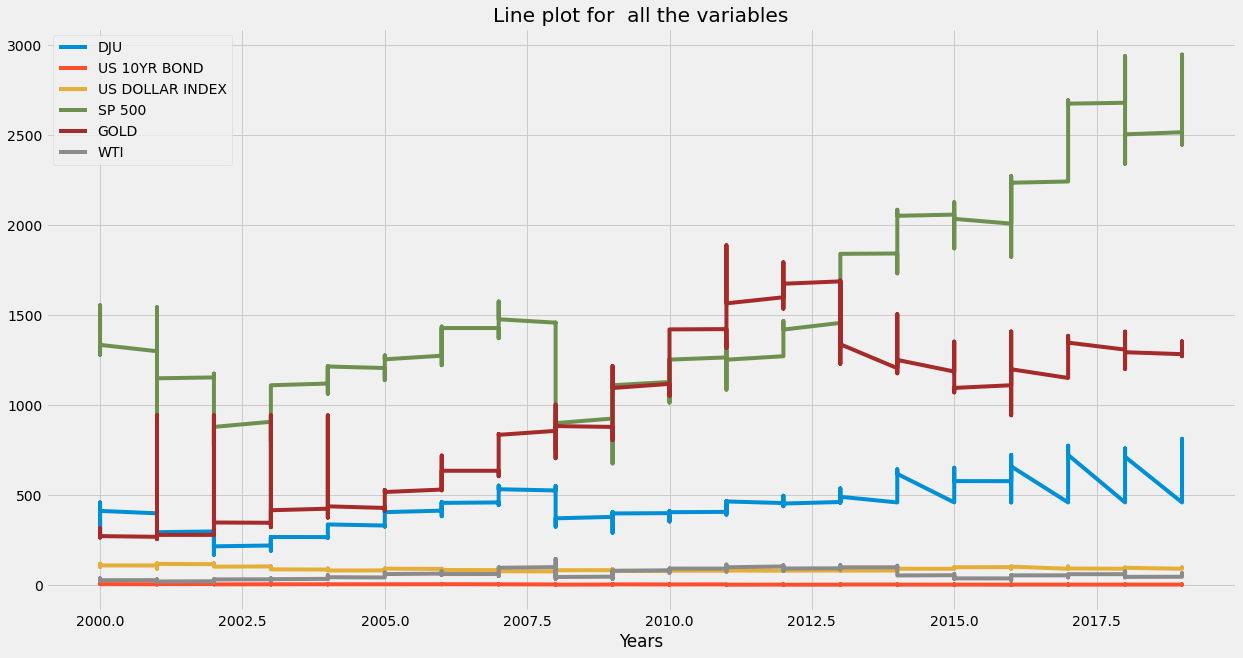

In [ ]:
## Temporary DataFrame
tdata = df
tdata['Year'] = df.index.year
#Line Plot Year Wise
plt.figure(figsize=(19,10))
plt.plot(tdata['Year'], df['DJU'], label='DJU')
plt.plot(tdata['Year'], df['US 10YR BOND'], label='US 10YR BOND')
plt.plot(tdata['Year'], df['US DOLLAR INDEX'], label='US DOLLAR INDEX')
plt.plot(tdata['Year'], df['SP 500'], label='SP 500')
plt.plot(tdata['Year'], df['GOLD'], label='GOLD',color='brown')
plt.plot(tdata['Year'], df['WTI'], label='WTI')
plt.xlabel("Years")
plt.legend()
plt.title('Line plot for  all the variables')
plt.show()

Model

1. Feature selection - eliminate features by Filteration technique and use correlation factor . ->We eliminate all features having spearman correlation less than magnitude of 0.4.
->We remove SP 500 and US 10 YR Bond ,we also thereby eliminate Multicollinearity present among (SP 500 & DJU),(US 10 YR BOND & DJU),(GOLD & DJU).

Features remaining : WTI ,GOLD , US DOLLAR INDEX. Since this is time series problem even WTI will be included as a feature as it is a autoregressive problem.

In [ ]:
##Feature Selection
after_fs = df[['WTI','GOLD','US DOLLAR INDEX']]
after_fs.head(3)

,WTI,GOLD,US DOLLAR INDEX
Date,,,
2000-01-04,25.55,282.7,100.10
2000-01-05,24.91,281.1,100.05
2000-01-06,24.78,281.4,100.34


2. Outlier Elimination

In [ ]:
# Method-1 - Financial Crisis Outlier Removal (2007-2009)
#We observed financial crisis from 2007 to 2009. We remove data points from mid of 2007 to mid of 2019 as this was a big crisis 
#and led to lot of volatality of oil price movement as observed earlier. We eliminated 482 outliers.
before_2007 = after_fs['2000-01':'2007-06']
after_2009 = after_fs['2009-06':'2019-06']
fin_out = pd.concat([before_2007,after_2009],axis=0)
fin_out.shape

(4465, 3)

In [ ]:
#(Method-2) Z-Score Outlier Removal Technique
#We can use Z-scores to detect outliers by calculating how many standard deviations away is a point from the mean.
zscore = np.abs(zs(after_fs['WTI']))
zscore_df = after_fs.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

,WTI,GOLD,US DOLLAR INDEX,zscore
Date,,,,
2000-01-04,25.55,282.7,100.10,1.379755
2000-01-05,24.91,281.1,100.05,1.403936
2000-01-06,24.78,281.4,100.34,1.408847
2000-01-07,24.22,281.9,100.50,1.430005
2000-01-10,24.67,281.7,100.65,1.413003


In [ ]:
##Considering Outliers of more than +-2.5 zscore as outliers
len(zscore_df[zscore_df['zscore']>2.5])

37

In [ ]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.5,['WTI','GOLD','US DOLLAR INDEX']]
zscore_df.shape

(4910, 3)

We considered all points of more than 2.5 times away from mean as outliers and removed 37 datapoints. Z-score can be calculated on univariate series so we used it on our target variable WTI and removed corresponding points.

In [ ]:
#(Method-3) Mahalanobis Distance Outlier Removal Technique
#Mahalanobis distance is distance between two points in a multivariate space. It can be effectively used to eliminate outliers when :-
#-> There is correlation with target variable.
#-> Multi-dimensional distance is possible otherwise not possible in Euclidean distance.
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy_linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [ ]:
mah_df = after_fs.copy()
mah_df['Mahalanobis'] = mahalanobis(x=mah_df, data=mah_df)
mah_df.head(3)

,WTI,GOLD,US DOLLAR INDEX,Mahalanobis
Date,,,,
2000-01-04,25.55,282.7,100.10,2.587267
2000-01-05,24.91,281.1,100.05,2.680037
2000-01-06,24.78,281.4,100.34,2.647445


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


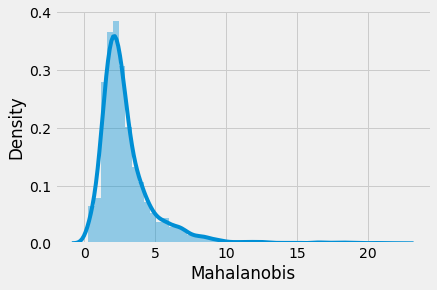

In [ ]:
sns.distplot(mah_df['Mahalanobis'])

In [ ]:
##We consider points with Mahalanobis distance greater than 8 to be outliers.
len(mah_df[mah_df['Mahalanobis']>8])

148

In [ ]:
#We removed 145 datapoints by using Mahalanobis distance.
mah_df = mah_df.loc[mah_df['Mahalanobis']<8,['WTI','GOLD','US DOLLAR INDEX']]

3. Splitting

In [ ]:
fin_train,fin_test = split(fin_out,train_size=0.7,shuffle=False)
z_train,z_test = split(zscore_df,train_size=0.7,shuffle=False)
mah_train,mah_test = split(mah_df,train_size=0.7,shuffle=False)
van_train,van_test = split(after_fs,train_size=0.7,shuffle=False)

In [ ]:
print('Fin Outlier Dataset')
print(fin_train.shape)
print(fin_test.shape)
print('Zscore Dataset')
print(z_train.shape)
print(z_test.shape)
print('Mahalanobis Dataset')
print(mah_train.shape)
print(mah_test.shape)
print('Vanilla Model-No Outlier Elimination')
print(van_train.shape)
print(van_test.shape)

Fin Outlier Dataset
(3125, 3)
(1340, 3)
Zscore Dataset
(3437, 3)
(1473, 3)
Mahalanobis Dataset
(3359, 3)
(1440, 3)
Vanilla Model-No Outlier Elimination
(3462, 3)
(1485, 3)


LSTM

In [ ]:
def prepare_train_data_lstm(scaler,train_data,n_dim):
  input_data = scaler.fit_transform(train_data.values)
  print('Shape of Input Data Initially',input_data.shape)
  timesteps = 60
  global X1
  X1 = []
  global y1
  y1=[]
  for i in range(len(input_data)-timesteps-1):
    t=[]
    for j in range(0,timesteps):        
      
        t.append(input_data[[(i+j)], :])
    X1.append(t)
    y1.append(input_data[i+ timesteps,0])
  
  X1, y1= np.array(X1), np.array(y1)
  print('Shape of Train Part after transformation',X1.shape)
  print('Shape of Test Part after transformation ',y1.shape)
  
  X1 = X1.reshape(X1.shape[0],timesteps, n_dim)
  print('Final Shape ',X1.shape)
  return X1,y1

In [ ]:
##LSTM Model Function
import tensorflow as tf
def lstm_model(scaler,train_data,n_dim):
#initialize model
  prepare_train_data_lstm(scaler,train_data,n_dim)

  global model
  model = Sequential()
 
#layer 1 of LSTM
  model.add(LSTM(units=30,return_sequences=True,input_shape=(X1.shape[1],n_dim)))
  model.add(Dropout(0.2))
 
#layer 2 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))
 
#layer 3 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))
 
#layer 4 of LSTM
  model.add(LSTM(units=30))
  model.add(Dropout(0.2))
 
#Output layer of model
  model.add(Dense(units=1))

  optimizer = tf.keras.optimizers.Adam(lr=2e-5)
#compiling the model
  model.compile(optimizer=optimizer,loss='mean_squared_error')
  model.fit(X1, y1, epochs=50, batch_size=32)

In [ ]:
##Function to Prepare Test Data
def prepare_test_data_lstm(scaler,test_data,n_dim):
  inputs = scaler.transform(test_data.values)
  global X_test
  X_test = []
  timesteps = 60
  for i in range(len(inputs)-timesteps-1):
      t=[]
      for j in range(0,timesteps):
        
          t.append(inputs[[(i+j)], :])
      X_test.append(t)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_dim))
  print('Shape of Test Dataset',X_test.shape)

In [ ]:
##Function to Predict Data
def predict_data(model_name,scaler_pred,test_data,X_test,Outlier_method,n_dim):
  
  pred = model_name.predict(X_test)
  print(len(test_data[61:]))
  set_scale = scaler_pred.fit_transform(test_data.iloc[61:,0].values.reshape(-1,1))
  pred_descale = scaler_pred.inverse_transform(pred)
  global pred_df
  pred_df = pd.DataFrame(pred_descale,columns=['Predicted -'+str(Outlier_method)])
  return pred_df

In [ ]:
##Function to Calculate Result Metrics
def result_metrics_forecast(test_series,forecast_series,model_name,out_name):
  print('Result Metrics for ' +  str(model_name) + ' -{} Outlier Removal Technique'.format(out_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(10,10))
  plt.plot(test_series.index,test_series,label='Actual')
  plt.plot(test_series.index,forecast_series,label='Predicted')
  plt.title(str(model_name) + ' -Forecasting Using {} Outlier Removal Technique'.format(out_name))
  plt.ylabel('Price')
  plt.legend()

In [ ]:
##We did MinMaxScaling
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

Hyper-parameter Tuning Learning rate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss',patience = 20)
X1,y1 = prepare_train_data_lstm(sc1,fin_train,3)

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)


In [ ]:
""" 
About this model : -
3 Layers of LSTM 
1 Hidden Layer
Output Layer- learning rate is being optimized 
Optimizer function is Adam
""" 
import tensorflow as tf

## 4 layers of LSTM Model
model_simple = Sequential()
 
#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer 
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))


#compiling the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model_simple.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

##Model Fit
history_simple = model_simple.fit(X1, y1, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
67/67 [==============================] - 16s 116ms/step - loss: 0.0773 - mae: 0.3117 - val_loss: 0.4163 - val_mae: 0.9089 - lr: 1.0000e-08
Epoch 2/200
67/67 [==============================] - 6s 89ms/step - loss: 0.0772 - mae: 0.3109 - val_loss: 0.4162 - val_mae: 0.9089 - lr: 1.2589e-08
Epoch 3/200
67/67 [==============================] - 6s 89ms/step - loss: 0.0771 - mae: 0.3107 - val_loss: 0.4162 - val_mae: 0.9088 - lr: 1.5849e-08
Epoch 4/200
67/67 [==============================] - 6s 88ms/step - loss: 0.0770 - mae: 0.3111 - val_loss: 0.4161 - val_mae: 0.9087 - lr: 1.9953e-08
Epoch 5/200
67/67 [==============================] - 6s 89ms/step - loss: 0.0774 - mae: 0.3111 - val_loss: 0.4160 - val_mae: 0.9086 - lr: 2.5119e-08
Epoch 6/200
67/67 [==============================] - 7s 102ms/step - loss: 0.0771 - mae: 0.3117 - val_loss: 0.4158 - val_mae: 0.9084 - lr: 3.1623e-08
Epoch 7/200
67/67 [==============================] - 6s 95ms/step - loss: 0.0772 - mae: 0.3115 - val_lo

Text(0.5, 1.0, 'Learning Rate vs Loss')

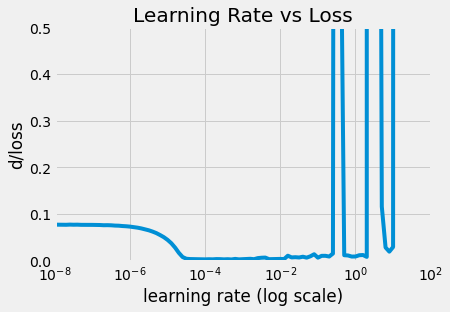

In [ ]:
plt.semilogx(history_simple.history["lr"], history_simple.history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss')

(1e-05, 100)

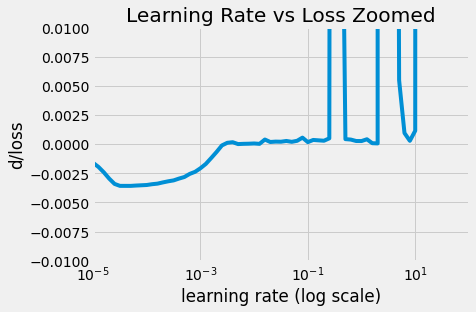

In [ ]:
sma=20
n_skip=20
y_lim=(-0.01,0.01)
"""
Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
derivatives = [0] * (sma + 1)
for i in range(1 + sma,200):
  derivative = (history_simple.history["loss"][i] - history_simple.history["loss"][i - sma]) / sma
  derivatives.append(derivative)
        
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss Zoomed')
plt.plot(history_simple.history["lr"][20:], derivatives[20:])
plt.xscale('log')
plt.ylim(y_lim)
plt.xlim(1e-5,100)

In [ ]:
##8e-4 is the optimal learning rate.
## 4 layers of LSTM Model
model_simple = Sequential()
#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer 
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))

#compiling the model

optimizer = tf.keras.optimizers.Adam(lr=2e-5)
model_simple.compile(loss=tf.keras.losses.MSE,
              optimizer=optimizer)

history_simple = model_simple.fit(X1, y1, epochs=40, batch_size=32,validation_split=0.3,shuffle=False)

Epoch 1/40
67/67 [==============================] - 15s 130ms/step - loss: 0.0890 - val_loss: 0.3360
Epoch 2/40
67/67 [==============================] - 6s 91ms/step - loss: 0.0399 - val_loss: 0.1681
Epoch 3/40
67/67 [==============================] - 7s 106ms/step - loss: 0.0222 - val_loss: 0.0784
Epoch 4/40
67/67 [==============================] - 6s 89ms/step - loss: 0.0153 - val_loss: 0.0349
Epoch 5/40
67/67 [==============================] - 6s 89ms/step - loss: 0.0103 - val_loss: 0.0169
Epoch 6/40
67/67 [==============================] - 6s 89ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 7/40
67/67 [==============================] - 6s 89ms/step - loss: 0.0078 - val_loss: 0.0095
Epoch 8/40
67/67 [==============================] - 6s 88ms/step - loss: 0.0077 - val_loss: 0.0096
Epoch 9/40
67/67 [==============================] - 6s 88ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 10/40
67/67 [==============================] - 6s 89ms/step - loss: 0.0076 - val_loss: 0.0095
Epoch 

<Figure size 432x288 with 0 Axes>

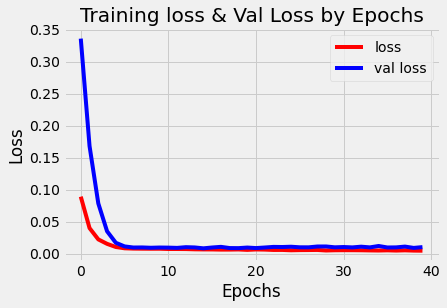

<Figure size 432x288 with 0 Axes>

In [ ]:
loss=history_simple.history['loss']
val_loss = history_simple.history['val_loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()

Forecasting using LSTM

In [ ]:
##Forecasting for Financial Outlier 
lstm_model(sc1,fin_train,3)

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


96/96 [==============================] - 16s 95ms/step - loss: 0.2231
Epoch 2/50
96/96 [==============================] - 9s 95ms/step - loss: 0.1367
Epoch 3/50
96/96 [==============================] - 9s 94ms/step - loss: 0.0585
Epoch 4/50
96/96 [==============================] - 9s 95ms/step - loss: 0.0302
Epoch 5/50
96/96 [==============================] - 10s 106ms/step - loss: 0.0170
Epoch 6/50
96/96 [==============================] - 10s 105ms/step - loss: 0.0120
Epoch 7/50
96/96 [==============================] - 9s 95ms/step - loss: 0.0109
Epoch 8/50
96/96 [==============================] - 9s 94ms/step - loss: 0.0102
Epoch 9/50
96/96 [==============================] - 9s 95ms/step - loss: 0.0099
Epoch 10/50
96/96 [==============================] - 9s 96ms/step - loss: 0.0098
Epoch 11/50
96/96 [==============================] - 9s 96ms/step - loss: 0.0097
Epoch 12/50
96/96 [==============================] - 9s 96ms/step - loss: 0.0088
Epoch 13/50
96/96 [========================

In [ ]:
prepare_test_data_lstm(sc1,fin_test,3)

Shape of Test Dataset (1279, 60, 3)


In [ ]:
predict_data(model,sc2,fin_test,X_test,'Financial Outlier',3)

40/40 [==============================] - 3s 25ms/step
1279


,Predicted -Financial Outlier
0,87.999557
1,87.917839
2,87.825287
3,87.721870
4,87.608322
...,...
1274,62.198887
1275,62.044422
1276,61.866493
1277,61.664478


In [ ]:
fin_out_pred = pred_df.copy()
fin_out_actual = fin_test.iloc[61:,0].copy()

Result Metrics for LSTM -Financial Outlier Removal Technique
R2 Score :  0.787
Mean Squared Error :  35.004
Mean Absolute Error :  4.628


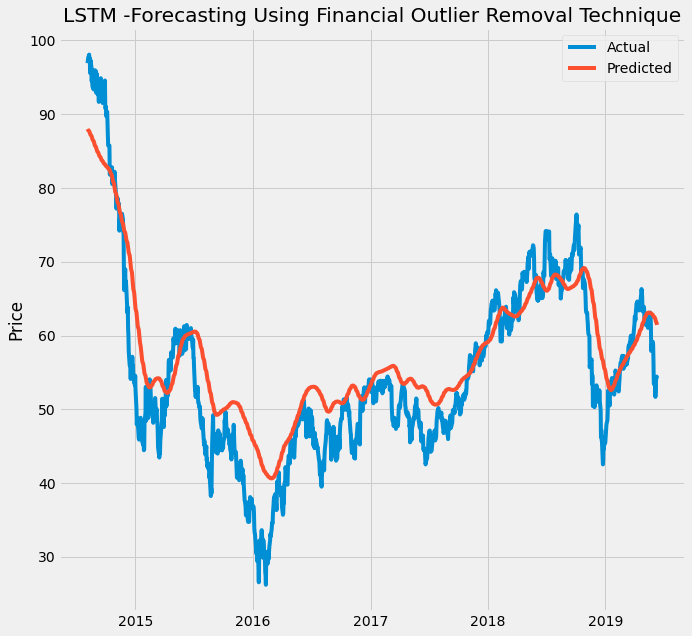

In [ ]:
result_metrics_forecast(fin_out_actual,fin_out_pred,'LSTM','Financial')

In [ ]:
##Forecasting For Z-Score Outlier Removed Dataset 
lstm_model(sc1,z_train,3)

Shape of Input Data Initially (3437, 3)
Shape of Train Part after transformation (3376, 60, 1, 3)
Shape of Test Part after transformation  (3376,)
Final Shape  (3376, 60, 3)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


106/106 [==============================] - 18s 96ms/step - loss: 0.2095
Epoch 2/50
106/106 [==============================] - 10s 96ms/step - loss: 0.1005
Epoch 3/50
106/106 [==============================] - 11s 104ms/step - loss: 0.0236
Epoch 4/50
106/106 [==============================] - 10s 96ms/step - loss: 0.0146
Epoch 5/50
106/106 [==============================] - 10s 96ms/step - loss: 0.0131
Epoch 6/50
106/106 [==============================] - 10s 96ms/step - loss: 0.0120
Epoch 7/50
106/106 [==============================] - 10s 95ms/step - loss: 0.0110
Epoch 8/50
106/106 [==============================] - 10s 95ms/step - loss: 0.0112
Epoch 9/50
106/106 [==============================] - 10s 96ms/step - loss: 0.0105
Epoch 10/50
106/106 [==============================] - 10s 97ms/step - loss: 0.0100
Epoch 11/50
106/106 [==============================] - 12s 116ms/step - loss: 0.0092
Epoch 12/50
106/106 [==============================] - 10s 97ms/step - loss: 0.0090
Epoch 13/5

In [ ]:
prepare_test_data_lstm(sc1,z_test,3)

Shape of Test Dataset (1412, 60, 3)


In [ ]:
print(sc1)

MinMaxScaler()


In [ ]:
predict_data(model,sc2,z_test,X_test,'Z-Score Outlier',3)

45/45 [==============================] - 3s 25ms/step
1412


,Predicted -Z-Score Outlier
0,81.500885
1,81.428474
2,81.386192
3,81.372643
4,81.384911
...,...
1407,56.668999
1408,56.519356
1409,56.347282
1410,56.151955


In [ ]:
z_out_pred = pred_df.copy()
z_out_actual = z_test.iloc[61:,0].copy()

Result Metrics for LSTM -ZScore Outlier Removal Technique
R2 Score :  0.843
Mean Squared Error :  53.255
Mean Absolute Error :  5.587


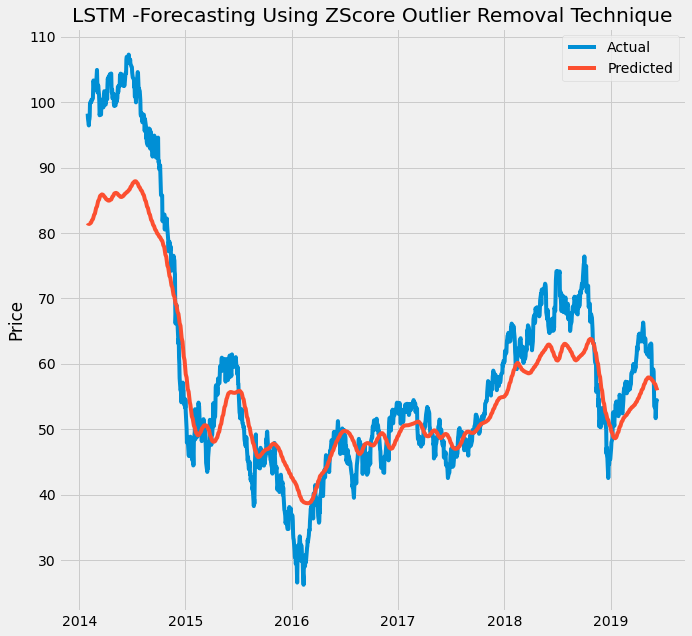

In [ ]:
result_metrics_forecast(z_out_actual,z_out_pred,'LSTM','ZScore')

In [ ]:
##Forecasting For Mahalanobis Outlier Removed Dataset
lstm_model(sc1,mah_train,3)

Shape of Input Data Initially (3359, 3)
Shape of Train Part after transformation (3298, 60, 1, 3)
Shape of Test Part after transformation  (3298,)
Final Shape  (3298, 60, 3)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


104/104 [==============================] - 17s 95ms/step - loss: 0.2488
Epoch 2/50
104/104 [==============================] - 10s 96ms/step - loss: 0.1068
Epoch 3/50
104/104 [==============================] - 10s 96ms/step - loss: 0.0318
Epoch 4/50
104/104 [==============================] - 11s 106ms/step - loss: 0.0158
Epoch 5/50
104/104 [==============================] - 10s 95ms/step - loss: 0.0110
Epoch 6/50
104/104 [==============================] - 10s 95ms/step - loss: 0.0098
Epoch 7/50
104/104 [==============================] - 10s 96ms/step - loss: 0.0098
Epoch 8/50
104/104 [==============================] - 10s 96ms/step - loss: 0.0097
Epoch 9/50
104/104 [==============================] - 10s 95ms/step - loss: 0.0096
Epoch 10/50
104/104 [==============================] - 10s 95ms/step - loss: 0.0091
Epoch 11/50
104/104 [==============================] - 10s 95ms/step - loss: 0.0094
Epoch 12/50
104/104 [==============================] - 11s 105ms/step - loss: 0.0086
Epoch 13/5

In [ ]:
prepare_test_data_lstm(sc1,mah_test,3)

Shape of Test Dataset (1379, 60, 3)


In [ ]:
predict_data(model,sc2,mah_test,X_test,'Mahalanobis Distance Outlier',3)

44/44 [==============================] - 3s 25ms/step
1379


,Predicted -Mahalanobis Distance Outlier
0,95.382057
1,95.475159
2,95.542862
3,95.586617
4,95.609489
...,...
1374,61.026127
1375,60.864090
1376,60.671848
1377,60.448086


Result Metrics for LSTM -Mahalanobis Outlier Removal Technique
R2 Score :  0.908
Mean Squared Error :  28.205
Mean Absolute Error :  4.03


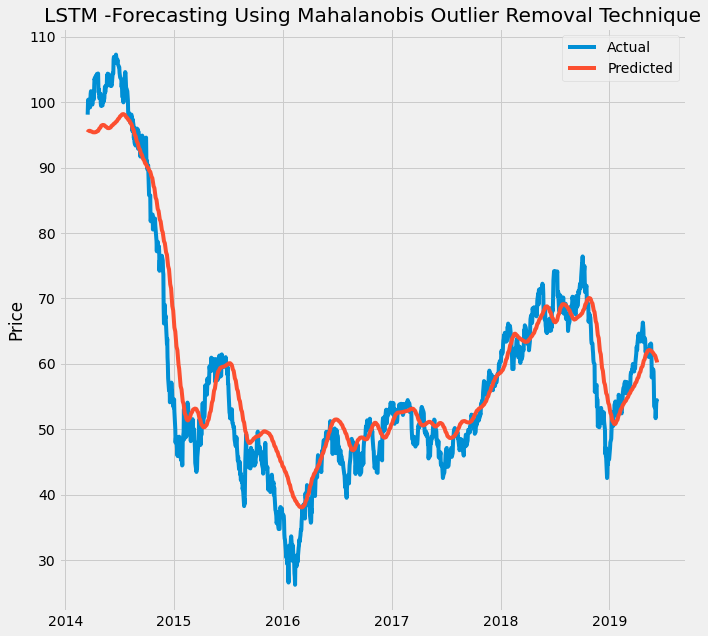

In [ ]:
mah_out_pred = pred_df.copy()
mah_out_actual = mah_test.iloc[61:,0].copy()
result_metrics_forecast(mah_out_actual,mah_out_pred,'LSTM','Mahalanobis')

In [ ]:
##Forecasting Vanilla Model-Without Outlier Removal
lstm_model(sc1,van_train,3)

Shape of Input Data Initially (3462, 3)
Shape of Train Part after transformation (3401, 60, 1, 3)
Shape of Test Part after transformation  (3401,)
Final Shape  (3401, 60, 3)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


107/107 [==============================] - 20s 107ms/step - loss: 0.1430
Epoch 2/50
107/107 [==============================] - 10s 97ms/step - loss: 0.0684
Epoch 3/50
107/107 [==============================] - 10s 98ms/step - loss: 0.0203
Epoch 4/50
107/107 [==============================] - 10s 97ms/step - loss: 0.0145
Epoch 5/50
107/107 [==============================] - 10s 97ms/step - loss: 0.0135
Epoch 6/50
107/107 [==============================] - 10s 97ms/step - loss: 0.0124
Epoch 7/50
107/107 [==============================] - 11s 107ms/step - loss: 0.0107
Epoch 8/50
107/107 [==============================] - 10s 96ms/step - loss: 0.0090
Epoch 9/50
107/107 [==============================] - 10s 96ms/step - loss: 0.0082
Epoch 10/50
107/107 [==============================] - 10s 96ms/step - loss: 0.0077
Epoch 11/50
107/107 [==============================] - 10s 97ms/step - loss: 0.0070
Epoch 12/50
107/107 [==============================] - 10s 96ms/step - loss: 0.0066
Epoch 13/5

In [ ]:
prepare_test_data_lstm(sc1,van_test,3)

Shape of Test Dataset (1424, 60, 3)


In [ ]:
predict_data(model,sc2,van_test,X_test,'Vanilla Model',3)

45/45 [==============================] - 3s 24ms/step
1424


,Predicted -Vanilla Model
0,76.244972
1,76.134743
2,75.997910
3,75.842781
4,75.677528
...,...
1419,52.600834
1420,52.457005
1421,52.288387
1422,52.096199


In [ ]:
van_pred = pred_df.copy()
van_actual = van_test.iloc[61:,0].copy()

Result Metrics for LSTM -Vanilla Model-No Outlier Removal Technique
R2 Score :  0.691
Mean Squared Error :  107.214
Mean Absolute Error :  7.744


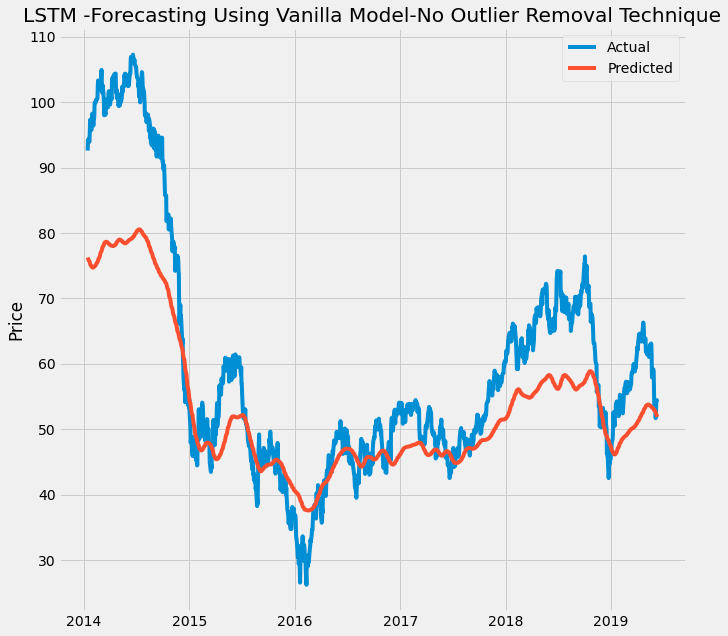

In [ ]:
result_metrics_forecast(van_actual,van_pred,'LSTM','Vanilla Model-No')

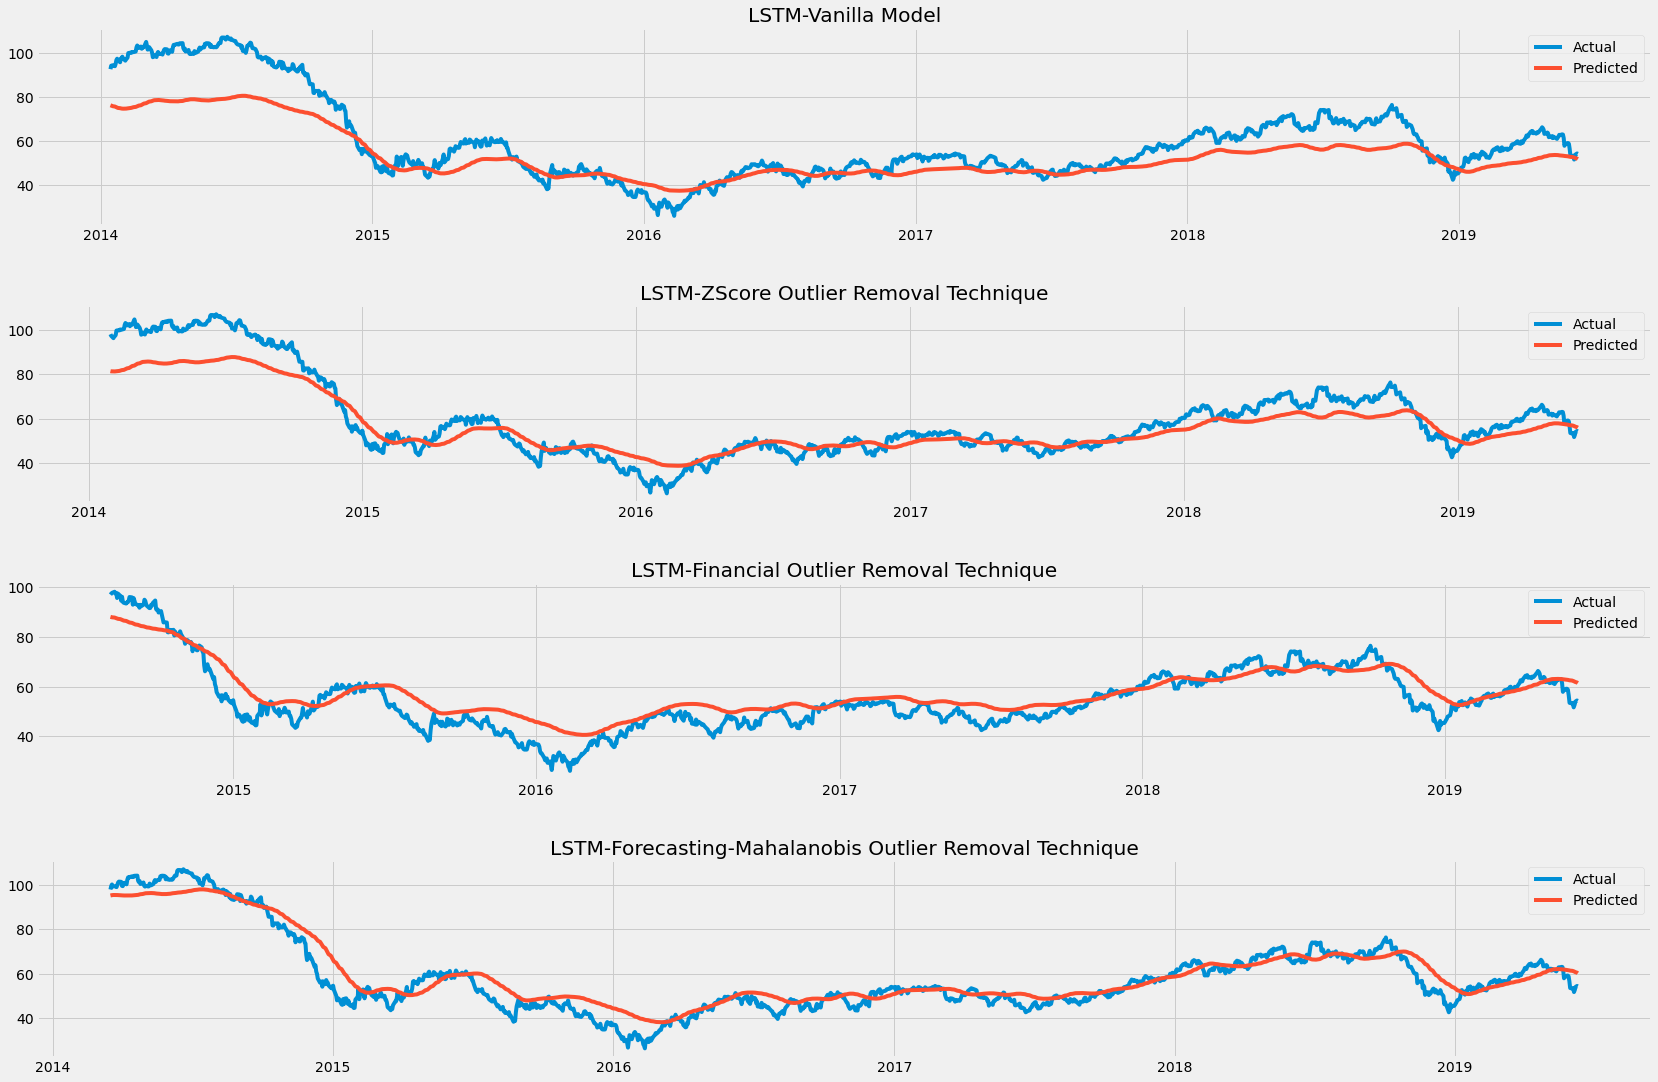

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(24,16))

ax1.plot(van_actual.index,van_actual,label='Actual')
ax1.plot(van_actual.index,van_pred,label='Predicted')
plt.title('Forecasting-No Outlier Removal Technique')
ax1.set_title('LSTM-Vanilla Model')

ax2.plot(z_out_actual.index,z_out_actual,label='Actual')
ax2.plot(z_out_actual.index,z_out_pred,label='Predicted')
ax2.set_title('LSTM-ZScore Outlier Removal Technique')

ax3.plot(fin_out_actual.index,fin_out_actual,label='Actual')
ax3.plot(fin_out_actual.index,fin_out_pred,label='Predicted')
ax3.set_title('LSTM-Financial Outlier Removal Technique')

ax4.plot(mah_out_actual.index,mah_out_actual,label='Actual')
ax4.plot(mah_out_actual.index,mah_out_pred,label='Predicted')
ax4.set_title('LSTM-Forecasting-Mahalanobis Outlier Removal Technique')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout(pad=3)

Result: Lstm worked well for prediction of WTI.